# 简单的车道线检测

##### 此notebook为首次尝试，主要目的熟悉使用opencv对图像做检测，选用了路况较为简单的高速路图片

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import numpy as np
import cv2

## 1.原图

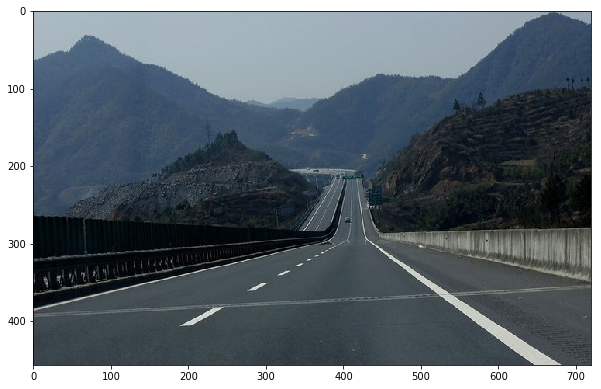

In [5]:
img = mplimg.imread('highway.jpg')
plt.figure(figsize=(10,10))
plt.imshow(img)

## 2.灰度图

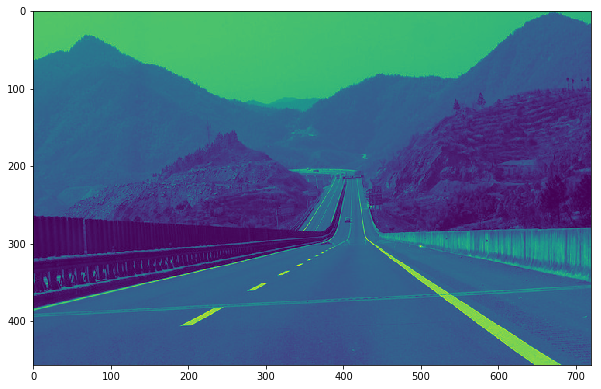

In [6]:
'''
1.灰度图读出偏绿色，原因暂未知，如下代码可获得灰色图片：
    for i in range(375):
        for j in range(1242):
            img[i,j] = (img[i,j,0]+img[i,j,1]+img[i,j,2]) / 3
    print(img)
    plt.figure(figsize=(15,5))
    plt.imshow(img)
    gray = img
2.可用cv2.cvtColor()将原图转换为灰度图，但在做Canny edge detection时会报错"src_depth() == 0 in canny function"，原因暂未知。
'''

gray = cv2.imread('highway.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
plt.imshow(gray)

## 3.高斯滤波

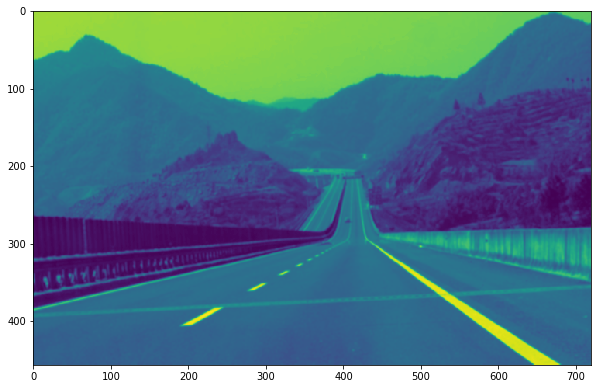

In [7]:
blur_ksize = 5
blur_gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0, 0)
plt.figure(figsize=(10,10))
plt.imshow(blur_gray)

## 4.Canny边界检测

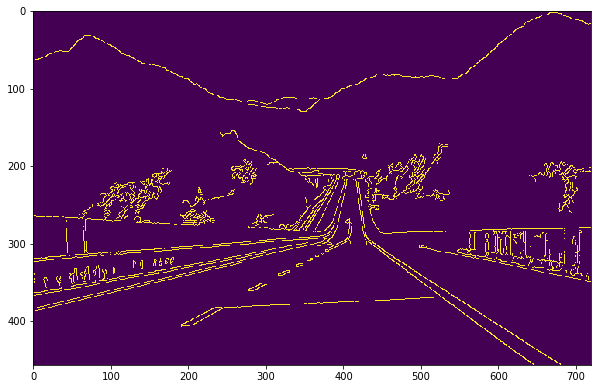

In [8]:
canny_lthreshold = 10  
canny_hthreshold = 150  
edges = cv2.Canny(blur_gray, canny_lthreshold, canny_hthreshold)
plt.figure(figsize=(10,10))
plt.imshow(edges)

## 5.Region of Interest (ROI)

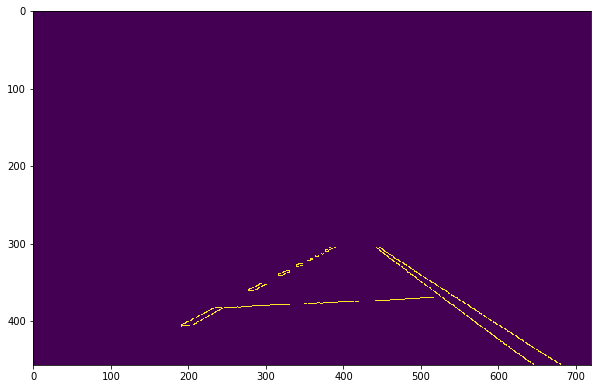

In [9]:
def roi_mask(img, vertices):
    
    mask = np.zeros_like(img)
    mask_color = 255
    cv2.fillPoly(mask,vertices,mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    
    return masked_img

roi_vertices = np.array([[(0,edges.shape[0]),
                          (380,305),
                          (450,305),
                          (edges.shape[1],edges.shape[0])]])
roi_edges = roi_mask(edges, roi_vertices)

plt.figure(figsize=(10,10))
plt.imshow(roi_edges)

## 6.Hough Transformation

(14, 1, 4)
(457, 720)


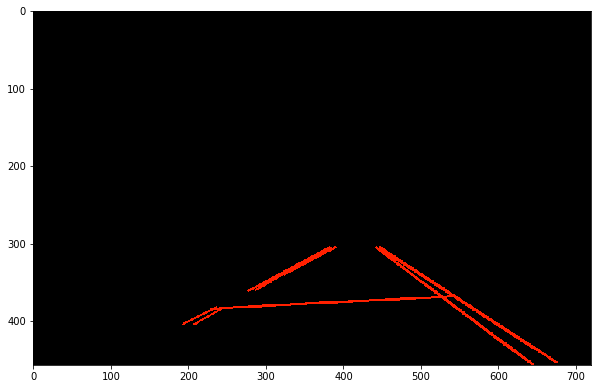

In [43]:
rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 40
max_line_gap = 20

def draw_lines(img, lines, color = (255, 0, 0), thickness = 2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    print(lines.shape)
    print(img.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

line_img = hough_lines(roi_edges, rho, theta, threshold, min_line_len, max_line_gap)

plt.figure(figsize=(10,10))
plt.imshow(line_img)

## 7.对检测出的直线进行筛选和拟合

left_vtx: [(376, 310), (99, 457)]
right_vtx: [(450, 310), (657, 457)]


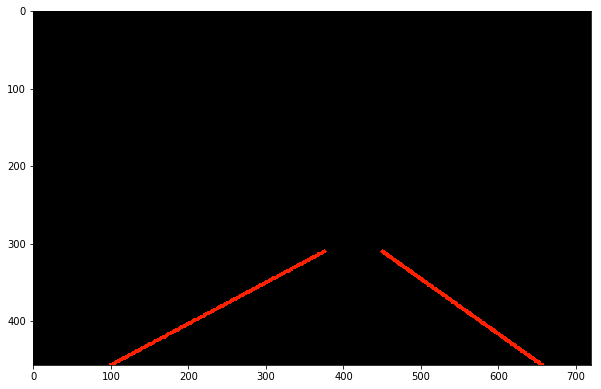

In [44]:
def draw_fit_lines(img, lines, color = (255, 0, 0), thickness = 3):
    left_lines, right_lines = [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2 - y1) / (x2 - x1)
            if k > 0:
                right_lines.append(line)
            else:
                left_lines.append(line)
    filtrate_lines(left_lines, 0.1)
    filtrate_lines(right_lines, 0.1)
                   
    left_points = [(x1, y1) for line in left_lines for x1,y1,x2,y2 in line]
    left_points = left_points + [(x2, y2) for line in left_lines for x1,y1,x2,y2 in line]
    right_points = [(x1, y1) for line in right_lines for x1,y1,x2,y2 in line]
    right_points = right_points + [(x2, y2) for line in right_lines for x1,y1,x2,y2 in line]
                   
    left_vtx = calc_lane_vertices(left_points, 310,img.shape[0])
    right_vtx = calc_lane_vertices(right_points, 310,img.shape[0])
                   
    cv2.line(img, left_vtx[0], left_vtx[1], color, thickness)
    cv2.line(img, right_vtx[0], right_vtx[1], color, thickness)
    print('left_vtx:',left_vtx)
    print('right_vtx:',right_vtx)
def filtrate_lines(lines, threshold):
    slope = [(y2 - y1) / (x2 - x1) for line in lines for x1, y1, x2, y2 in line]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s - mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
            break
                   
def calc_lane_vertices(point_list, ymin, ymax):
    x = [p[0] for p in point_list]
    y = [p[1] for p in point_list]
    fit = np.polyfit(y, x, 1)
    fit_fn = np.poly1d(fit)

    xmin = int(fit_fn(ymin))
    xmax = int(fit_fn(ymax))

    return [(xmin, ymin), (xmax, ymax)]
                
fit_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
lines = cv2.HoughLinesP(roi_edges, rho, theta, threshold, np.array([]),
                        minLineLength=min_line_len, 
                        maxLineGap=max_line_gap)                  
draw_fit_lines(fit_img, lines)
                   
plt.figure(figsize=(10,10))
plt.imshow(fit_img)

## 8.与原图叠加

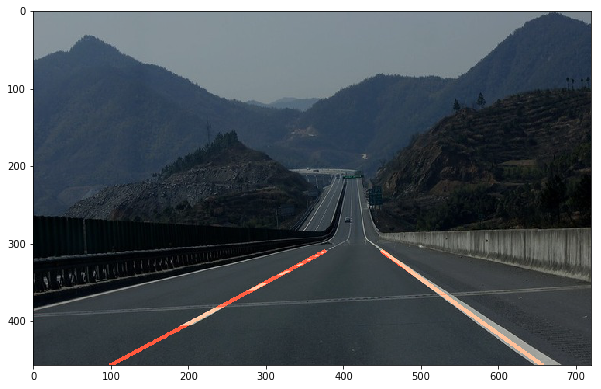

In [45]:
done_img = cv2.addWeighted(img, 0.8, fit_img, 1, 0)
plt.figure(figsize=(10,10))
plt.imshow(done_img)